## Step 2 : Multipole expansion

When we have a big number of particles, do direct sumations is computationally expensive. Instead of calculating all pair interactions, we will applied a tree code method. With this method we treat by direct sumation only the particles that are close to the target, and the ones that are in distant cells are treated as a single *pseudo-particle* centered at the cell's center of mass by applying a multipole expansion. 

In this notebook we will show the difference beteween doing multiple expansion and direct sumation for different target particles. 

First, we introduce multipole expansion at a cell's center. In a word, we want to decouple the interaction term $\frac{m_j}{r_{ij}}$ for the particles in a distance:

$$\begin{equation}
\Phi_i = \sum_{j=0}^N{\frac{m_j}{r_{ij}}} = \sum_{j=0}^N {A_j B_i}
\end{equation}$$

where $A_j$ is the term that only depends on source particles (*multipole*), and $B_i$ is the part depends on target particles (*weight*).

Recall the second-order taylor expansion in three variables $x$, $y$, $z$:

$$\begin{equation}\begin{split}
f(x,y,z) & \approx f(a,b,c) + \left(x-a\right)f_x(a,b,c) + \left(y-b\right)f_y(a,b,c) + \left(z-c\right)f_z(a,b,c) \\
& + \frac{1}{2!}[\left(x-a\right)^2f_{xx}(a,b,c) + \left(y-b\right)^2f_{yy}(a,b,c) + \left(z-c\right)^2f_{zz}(a,b,c) \\
& + 2\left(x-a\right)\left(y-b\right)f_{xy}(a,b,c) + 2\left(y-b\right)\left(z-c\right)f_{yz}(a,b,c) \\ 
& + 2\left(z-c\right)\left(x-a\right)f_{zx}(a,b,c)]
\end{split}\end{equation}$$

We assume that: 
$$f(x_j,y_j,z_j) = \frac{m_{j}}{r_{ij}} = \frac{m_{j}}{\sqrt{(x_i-x_j)^2 + (y_i-y_j)^2 + (z_i-z_j)^2}}$$ 

<img src="image/multipole.png">

Here we expand the interaction term $f(x_j,y_j,z_j)$ around a center point $(x_c, y_c, z_c)$ to the second order: 

$$\begin{equation}\begin{split}
f(x_j,y_j,z_j) & \approx f(x_c,y_c,z_c) + (x_j-x_c)\, f_{x_j}\rvert_c + (y_j-y_c)\, f_{y_j}\rvert_c + (z_j-z_c)\, f_{z_j}\rvert_c \\
& + \frac{1}{2!}[(x_j-x_c)^2f_{x_jx_j}\rvert_c + (y_j-y_c)^2f_{y_jy_j}\rvert_c + (z_j-z_c)^2f_{z_jz_j}\rvert_c \\
& + 2(x_j-x_c)(y_j-y_c)f_{x_jy_j}\rvert_c + 2(y_j-y_c)(z_j-z_c)f_{y_jz_j}\rvert_c \\ 
& + 2(z_j-z_c)(x_j-x_c)f_{z_jx_j}\rvert_c]
\end{split}\end{equation}$$

then we calculate each derivative's value at the expansion center $(x_c,y_c,z_c)$:

$$\begin{equation}\begin{split}
& f_{x_j}\rvert_c = \frac{x_i-x_c}{R^3} m_j\\
& f_{x_jx_j}\rvert_c = \left(\frac{3(x_i-x_c)^2}{R^5} - \frac{1}{R^3}\right) m_j \\
& f_{x_jy_j}\rvert_c = \frac{3(x_i-x_c)(y_i-y_c)}{R^5} m_j
\end{split}\end{equation}$$

where $R$ is the distance between target particle $i$ and the cell's center $c$. Now let's write out the interaction term again:

$$\begin{equation}\begin{split}
\frac{m_j}{r_{ij}} & \approx \frac{m_j}{R} + m_j(x_c-x_j)\left(-\frac{x_i-x_c}{R^3}\right) + m_j(y_c-y_j)\left(-\frac{y_i-y_c}{R^3}\right) \\
& + m_j(z_c-z_j)\left(-\frac{z_i-z_c}{R^3}\right) + \frac{m_j(x_c-x_j)^2}{2}\left(\frac{3(x_i-x_c)^2}{R^5} - \frac{1}{R^3}\right) \\
& + \frac{m_j(y_c-y_j)^2}{2}\left(\frac{3(y_i-y_c)^2}{R^5} - \frac{1}{R^3}\right) + \frac{m_j(z_c-z_j)^2}{2}\left(\frac{3(z_i-z_c)^2}{R^5} - \frac{1}{R^3}\right) \\
& + \frac{m_j(x_c-x_j)(y_c-y_j)}{2}\frac{3(x_i-x_c)(y_i-y_c)}{R^5} \\
& + \frac{m_j(y_c-y_j)(z_c-z_j)}{2}\frac{3(y_i-y_c)(z_i-z_c)}{R^5} \\
& + \frac{m_j(z_c-z_j)(x_c-x_j)}{2}\frac{3(z_i-z_c)(x_i-x_c)}{R^5}
\end{split}\end{equation}$$

The multipoles have no relationship with target particles, so we can calculate those constants before looping in $i$. The second part in each term only depends on target particles $i$, so we can calculate this part in the loop. From above we can write the interaction term as:

$$\begin{equation}
\frac{m_j}{r_{ij}} = \sum_{k=1}^{10} A_k(j)\,B_k(i)
\end{equation}$$

Remember that what we just considered is only one source particle $j$'s effect on target $i$. In order to evaluate the potential $\Phi_i$, we need to take all the source particles into account:

$$\begin{equation}\begin{split}
\Phi_i & = \sum_{j=0}^N{\frac{m_j}{r_{ij}}} = \sum_{j=0}^N \sum_{k=1}^{10} A_k(j)\,B_k(i) \\
& = \sum_{k=1}^{10} \left(\sum_{j=0}^N A_k(j)\right) B_k(i)
\end{split}\end{equation}$$

In [1]:
# importing libraries
import numpy
from treecode_helper import Particle, Point
from matplotlib import pyplot, rcParams
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# customizing plot parameters
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 14
rcParams['font.family'] = 'StixGeneral'

In [2]:
n = 300     # number of particles
m = 1./n    # mass

# initialize sources and target
source_coords = numpy.random.random((n, 3)).tolist()
target_coords = (-numpy.random.random((3))).tolist()
sources = [ Particle(coord, m=m) for coord in source_coords ]
target =  Particle(target_coords, m=m) 

The multipole expansion converges and provides an accurate solution under two conditions:
* The sources are close to the expansion center (cell's center).
* The targets are located far enough from the expansion center.

Therefore, in this notebook, we assume there are $n$ sources located in the domain: $x_j$, $y_j$, $z_j$ $\in$ $\left[ 0, 1 \right]$, while $n$ targets in the domain: $x_i$, $y_i$, $z_i$ $\in$ $\left[ -1, 0 \right]$, in order to satisfy the convergence condition above. We also assume the sources are in a cubic cell whose center is located at $(0.5, 0.5, 0.5)$. Now let's initialize the problem.

In [3]:
center = Point([0.5, 0.5, 0.5])

In [4]:
#to understand how we sum along an axis

arr = numpy.array([[1, 2], [3, 4], [1, 1]])
#print(numpy.shape(arr))
arr_sum = numpy.sum(arr[:], axis=1)
arr_sum0 = numpy.sum(arr[:], axis=0)

print(arr)
print(arr_sum)
print(arr_sum0)

[[1 2]
 [3 4]
 [1 1]]
[3 7 2]
[5 7]


In [5]:
def P2M(sources, center):
    
    '''
    Given sources and cell's information, return the multipole.
    
    Argument:
    ---------
        sources: the list of source objects in Particle class.
        center: the point object of expansion center.
        
    Return:
    -------
        multipole: the multipole array of the cell.
    '''
    
    dx = center.x - numpy.array([source.x for source in sources])
    dy = center.y - numpy.array([source.y for source in sources])
    dz = center.z - numpy.array([source.z for source in sources])
    
    source_m = numpy.array([source.m for source in sources])
    
    #Calculate the contribution of each source (expression valid for
    #2nd order taylor expansion in 3D)
    
    multipole = source_m * [numpy.ones(n), dx, dy, dz, 0.5*dx**2, 0.5*dy**2,
                            0.5*dz**2, 0.5*dx*dy, 0.5*dy*dz, 0.5*dz*dx]
    
    
    #Sum the multipole over sources
    multipole = numpy.sum(multipole[:], axis = 1)
    
    return multipole
    
    

In [6]:
multipole = P2M(sources, center)

In [7]:
def eval_potential(target, multipole, center):
    """Given targets list, multipole and expansion center, return
    the array of target's potentials.
    
    Arguments:
        targets: the list of target objects in 'Particle' class
        multipole: the multipole array of the cell
        center: the point object of expansion center
    
    Returns:
        phi: the potential array of targets
        
    """
        
    # calculate the distance between each target and center
    r = target.distance(center)
    
    # prearrange some constants for weight
    dx, dy, dz = target.x-center.x, target.y-center.y, target.z-center.z
    r3 = r**3
    r5 = r3*r**2
    
    # calculate the weight for each multipole
    weight = [1/r, -dx/r3, -dy/r3, -dz/r3, 3*dx**2/r5 - 1/r3, \
              3*dy**2/r5 - 1/r3, 3*dz**2/r5 - 1/r3, 3*dx*dy/r5, \
              3*dy*dz/r5, 3*dz*dx/r5]
    
    # evaluate potential
    phi = numpy.dot(multipole, weight)
    return phi

In [8]:
phi_multi = eval_potential(target, multipole, center)

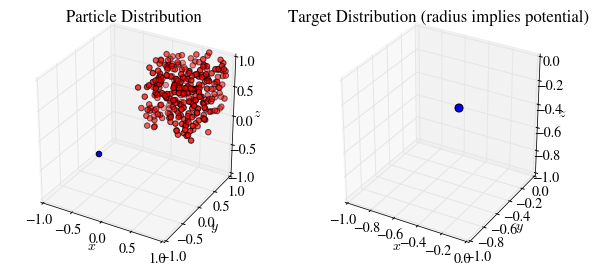

In [9]:
# plot spatial particle distribution
fig = pyplot.figure(figsize=(10,4.5))
# left plot
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(target.x, target.y, target.z, s=30, c='b')
ax.scatter([source.x for source in sources], 
           [source.y for source in sources], 
           [source.z for source in sources], s=30, c='r')

ax.scatter(center.x, center.y, center.z, s=30, c='g')

ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_title('Particle Distribution')
# right plot
ax = fig.add_subplot(1,2,2, projection='3d')
scale = 100   # scale for dot size in scatter plot
ax.scatter(target.x, target.y, target.z, s=phi_multi*scale, c='b')
ax.set_xlim3d(-1,0)
ax.set_ylim3d(-1,0)
ax.set_zlim3d(-1,0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Target Distribution (radius implies potential)');

In [10]:
def direct_sum(sources, target):
    """Calculate the gravitational potential (target.phi) at each target 
    particle using direct summation method.

    Arguments:
        sources: the list of source objects in 'Particle' class
        targets: the list of target objects in 'Particle' class

    """
    for source in sources:
        r = target.distance(source)
        target.phi += source.m/r

In [11]:
direct_sum(sources, target)
phi_direct = target.phi

In [12]:
%timeit direct_sum(sources, target)

1000 loops, best of 3: 1.77 ms per loop


In [13]:
%%timeit
multipole = P2M(sources, center)
eval_potential(target, multipole, center)

1000 loops, best of 3: 358 µs per loop


In [14]:
print(phi_multi)
print(phi_direct)


0.649181872364
0.650785007888


In [15]:
err = numpy.sqrt((phi_direct-phi_multi)**2/phi_direct**2)
print('L2 Norm error: {}'.format(err))

L2 Norm error: 0.002463387300126171


In [26]:
err_rel = abs((phi_multi - phi_direct) / phi_direct)
perc = numpy.round(err_rel*100, 2)

In [27]:
print("The relative error is {} %".format(perc))

The relative error is 0.25 %
